In [13]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# 모델과 이미지 전처리기 로드
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device
model.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [15]:
# 샘플 이미지 로드
sample = "./Validation/rose_img/07_20201028_567302.jpg"  # 이미지 URL
images=[]
image = Image.open(sample)
images.append(image)

# 이미지 전처리
inputs = processor(images=image, return_tensors="pt").to(device)


In [16]:
outputs = model(**inputs)

In [22]:
logits = outputs.logits
bboxes = outputs.pred_boxes


In [23]:
# COCO 데이터셋의 클래스 레이블
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

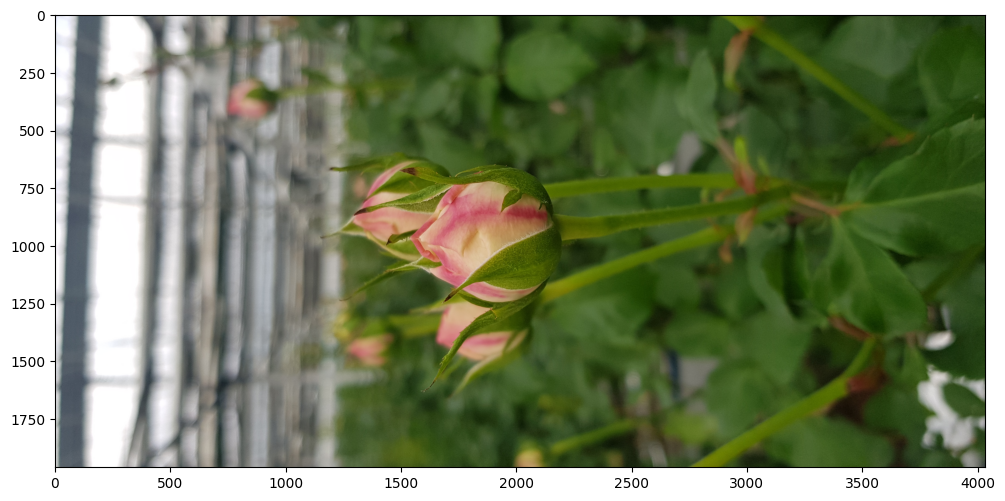

In [24]:
# 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.imshow(images[0])


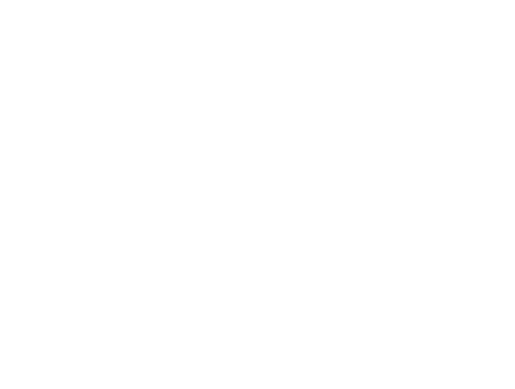

In [27]:
# 예측된 바운딩 박스와 레이블 표시
for logits_per_box, box in zip(logits[0], bboxes[0]):
    score = logits_per_box.softmax(-1).max(-1)[0]
    label = logits_per_box.softmax(-1).max(-1)[1].item()
    if score > 0.9:  # 임계값 0.9 설정
        box = box.cpu().detach().numpy()
        xmin, ymin, xmax, ymax = box * [images[0].width, images[0].height, images[0].width, images[0].height]
        if label < len(COCO_INSTANCE_CATEGORY_NAMES):
            ax.add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none'))
            ax.text(xmin, ymin, COCO_INSTANCE_CATEGORY_NAMES[label], fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis('off')
plt.show()